# GA Project 4: Predicting Domestic Airline Delays (USA)

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import precision_recall_curve, auc, recall_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from imblearn.combine import SMOTETomek 
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

%matplotlib inline


In [77]:
# Load dataset. Let's just work with 1 file first.

nov17 = pd.read_csv(r'/Users/CalvinChua/Desktop/delay_data/2017_Nov_ONTIME.csv')
dec17 = pd.read_csv(r'/Users/CalvinChua/Desktop/delay_data/2017_Dec_ONTIME.csv')
nov16 = pd.read_csv(r'/Users/CalvinChua/Desktop/delay_data/2016_Dec_ONTIME.csv')
dec16 = pd.read_csv(r'/Users/CalvinChua/Desktop/delay_data/2016_Nov_ONTIME.csv')
nov15 = pd.read_csv(r'/Users/CalvinChua/Desktop/delay_data/2015_Dec_ONTIME.csv')
dec15 = pd.read_csv(r'/Users/CalvinChua/Desktop/delay_data/2015_Nov_ONTIME.csv')
nov14 = pd.read_csv(r'/Users/CalvinChua/Desktop/delay_data/2014_Dec_ONTIME.csv')
dec14 = pd.read_csv(r'/Users/CalvinChua/Desktop/delay_data/2014_Nov_ONTIME.csv')

full_data = pd.concat([nov17, dec17, nov16, dec16, nov15, dec15, nov14, dec14,])


/Users/CalvinChua/Desktop/Data_Tools/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Is Data Usable?

In [78]:
# Number of unique values

full_data.nunique()


YEAR                      4
MONTH                     2
DAY_OF_MONTH             31
DAY_OF_WEEK               7
UNIQUE_CARRIER           15
TAIL_NUM               5814
FL_NUM                 7078
ORIGIN                  326
ORIGIN_CITY_NAME        322
DEST                    325
DEST_CITY_NAME          321
CRS_DEP_TIME           1326
DEP_TIME               1440
DEP_DELAY              1299
TAXI_OUT                174
TAXI_IN                 244
CRS_ARR_TIME           1438
ARR_TIME               1440
ARR_DELAY              1327
CANCELLED                 2
CANCELLATION_CODE         4
DIVERTED                  2
CRS_ELAPSED_TIME        562
ACTUAL_ELAPSED_TIME     717
AIR_TIME                690
DISTANCE               1432
CARRIER_DELAY          1122
WEATHER_DELAY           694
NAS_DELAY               576
SECURITY_DELAY          182
LATE_AIRCRAFT_DELAY     683
dtype: int64

In [79]:
# Are there enough non-null values to work with?

full_data.isnull().sum()


YEAR                         0
MONTH                        0
DAY_OF_MONTH                 0
DAY_OF_WEEK                  0
UNIQUE_CARRIER               0
TAIL_NUM                  4516
FL_NUM                       0
ORIGIN                       0
ORIGIN_CITY_NAME             0
DEST                         0
DEST_CITY_NAME               0
CRS_DEP_TIME                 0
DEP_TIME                 37516
DEP_DELAY                37520
TAXI_OUT                 38688
TAXI_IN                  40871
CRS_ARR_TIME                 0
ARR_TIME                 40871
ARR_DELAY                46962
CANCELLED                    0
CANCELLATION_CODE      3677479
DIVERTED                     0
CRS_ELAPSED_TIME             1
ACTUAL_ELAPSED_TIME      46962
AIR_TIME                 46962
DISTANCE                     0
CARRIER_DELAY          3055466
WEATHER_DELAY          3055466
NAS_DELAY              3055466
SECURITY_DELAY         3055466
LATE_AIRCRAFT_DELAY    3055466
dtype: int64

In [80]:
# Let's drop rows that lack data for important features
total_rows = len(full_data.index)
print("total_rows = " + str(total_rows))

full_data.dropna(subset = ['UNIQUE_CARRIER', 'DEP_DELAY', 'ORIGIN', 'ARR_DELAY'], inplace = True)
data_rows = len(full_data.index)
data_retained = (data_rows/total_rows)*100
print("Percentage of data retained: " + str(data_retained) + "%")


total_rows = 3716693
Percentage of data retained: 98.73645738294769%


# Exploratory Data Analysis (EDA)

In [81]:
# DELETE ROWS WITH airline "FL" due to airline closure
full_data = full_data[full_data.UNIQUE_CARRIER != 'FL']

# To change "US" -> "AA" due to a merging in 2015.
full_data = full_data.replace("US", "AA")

total_rows = len(full_data.index)
print("total_rows = " + str(total_rows))

full_data.dropna(subset = ['UNIQUE_CARRIER', 'DEP_DELAY', 'ORIGIN', 'ARR_DELAY'], inplace = True)
data_rows = len(full_data.index)
data_retained = (data_rows/total_rows)*100
print("Percentage of data retained: " + str(data_retained) + "%")


total_rows = 3662868
Percentage of data retained: 100.0%


In [82]:
# Do a categorical 'Delayed' column by get_dummies

# Add new column to categorise delay: 1 for delay, 0 for no delay
full_data['DELAYED'] = full_data['DEP_DELAY'] >= 15
full_data.DELAYED = full_data.DELAYED.astype(int)


17.71797400288517 percent of flights are late.


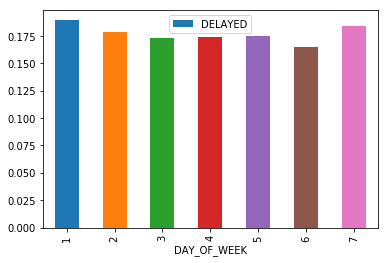

In [83]:
# Day vs Delayed count

# Amt of flights
late_pct = np.sum(full_data['DELAYED'])/len(full_data['DELAYED'])*100
print(str(late_pct) + " percent of flights are late.")

# Day-of-week vs % flights
weekday = full_data.groupby(['DAY_OF_WEEK'], as_index=False).agg(np.mean)[['DAY_OF_WEEK', 'DELAYED']]

weekday.sort_values(by='DAY_OF_WEEK')    
weekday.plot.bar(x='DAY_OF_WEEK', y='DELAYED')

#full_data.groupby('DAY_OF_WEEK').count()


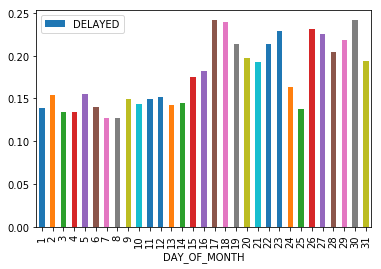

In [84]:
# Do graph of day_month and count

# day-of-month vs % flights
month_day = full_data.groupby(['DAY_OF_MONTH'], as_index=False).aggregate(np.mean)[['DAY_OF_MONTH', 'DELAYED']]
#month_day = full_data.groupby(['DAY_OF_MONTH'], as_index=False).aggregate(np.sum)[['DAY_OF_MONTH', 'DELAYED']]

month_day.sort_values(by='DAY_OF_MONTH', inplace=True)    
month_day.plot.bar(x='DAY_OF_MONTH', y='DELAYED')


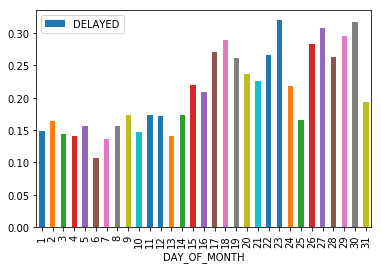

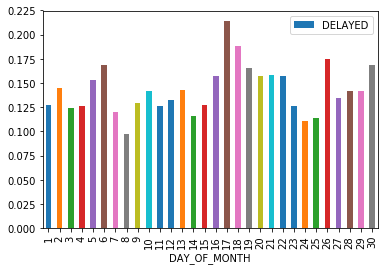

In [85]:
dec = full_data[full_data.MONTH == 12]
dec = dec.groupby(['DAY_OF_MONTH'], as_index=False).aggregate(np.mean)[['DAY_OF_MONTH', 'DELAYED']]

dec.sort_values(by='DAY_OF_MONTH', inplace=True)    
dec.plot.bar(x='DAY_OF_MONTH', y='DELAYED')

nov = full_data[full_data.MONTH == 11]
nov = nov.groupby(['DAY_OF_MONTH'], as_index=False).aggregate(np.mean)[['DAY_OF_MONTH', 'DELAYED']]

nov.sort_values(by='DAY_OF_MONTH', inplace=True)    
nov.plot.bar(x='DAY_OF_MONTH', y='DELAYED')


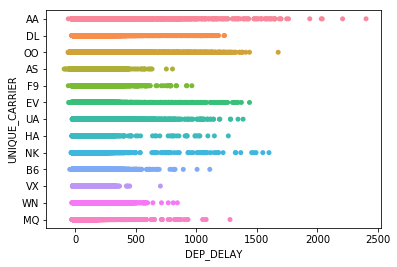

In [86]:
# Airlines vs Delay

airline_mins = sns.stripplot(x='DEP_DELAY', y='UNIQUE_CARRIER', data = full_data, orient='h')


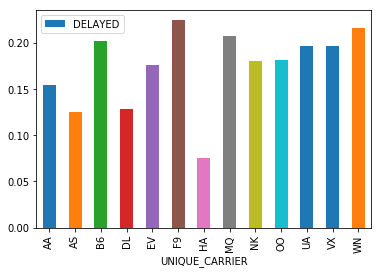

In [87]:
carrier = full_data.groupby(['UNIQUE_CARRIER'], as_index=False).aggregate(np.mean)[['UNIQUE_CARRIER', 'DELAYED']]
#carrier = full_data.groupby(['UNIQUE_CARRIER'], as_index=False).aggregate(np.sum)[['UNIQUE_CARRIER', 'DELAYED']]

carrier.sort_values(by='UNIQUE_CARRIER', inplace=True)
carrier.plot.bar(x='UNIQUE_CARRIER', y='DELAYED')


In [88]:
# Maybe origin causes the delays?

# origin vs % flights
#origin_city = full_data.groupby(['ORIGIN'], as_index=False).aggregate(np.mean)[['ORIGIN', 'DELAYED']]
#origin_city.sort_values(by='ORIGIN')    
#origin_city.plot.bar(x='ORIGIN', y='DELAYED')
#print(origin_city.sort_values(by='DELAYED', ascending= False))
#print(origin_city)

origin_city = full_data.groupby(['ORIGIN'], as_index=False).aggregate(np.mean)[['ORIGIN', 'DELAYED']]
print(origin_city.sort_values(by='DELAYED', ascending= False))
print(origin_city)

#origin_city = sns.stripplot(x='ORIGIN', y='DELAYED', data = full_data)


    ORIGIN   DELAYED
302    SWO  1.000000
192    MCN  1.000000
209    MMH  0.420000
55     CEC  0.417391
8      ADK  0.409836
17     ASE  0.367832
230    OTH  0.352000
137    HDN  0.338583
60     CIC  0.333333
162    JAC  0.307308
316    UIN  0.297297
97     EGE  0.291139
38     BPT  0.258575
317    UST  0.255556
82     DAL  0.241791
221    OAK  0.241690
6      ACV  0.238095
123    GGG  0.237342
106    EWR  0.237221
195    MDW  0.232001
278    SFO  0.223729
135    GUC  0.221757
233    PBG  0.221106
199    MFR  0.219178
142    HOU  0.218601
175    LAX  0.217318
153    ILG  0.216216
86     DEN  0.215478
246    PPG  0.213333
218    MTJ  0.210938
..     ...       ...
154    ILM  0.107744
133    GTF  0.106884
30     BIL  0.106679
146    HYS  0.106599
141    HOB  0.106173
96     ECP  0.105678
307    TRI  0.105350
178    LCH  0.104545
113    FLG  0.100971
107    EYW  0.099625
81     DAB  0.099543
15     ANC  0.099515
108    FAI  0.095142
7      ACY  0.094895
169    KOA  0.093197
323    YAK  0

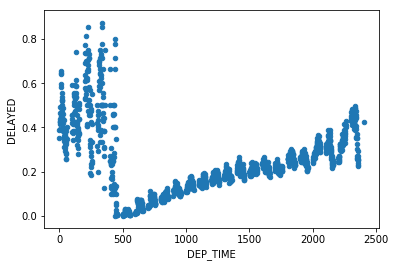

In [89]:
time = full_data.groupby(['DEP_TIME'], as_index=False).aggregate(np.mean)[['DEP_TIME', 'DELAYED']]
#carrier = full_data.groupby(['UNIQUE_CARRIER'], as_index=False).aggregate(np.sum)[['UNIQUE_CARRIER', 'DELAYED']]

time.sort_values(by='DEP_TIME', inplace=True)
time.plot.scatter(x='DEP_TIME', y='DELAYED')

#time = full_data.groupby(['DEP_TIME'], as_index=False).count()[['DEP_TIME', 'DELAYED']]
#print(time.sort_values(by='DELAYED', ascending= False))
#print(time)


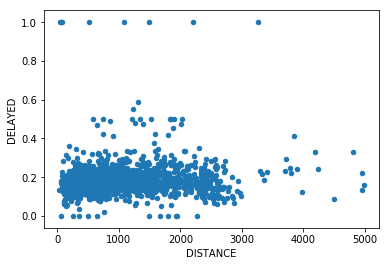

In [90]:
distance = full_data.groupby(['DISTANCE'], as_index=False).aggregate(np.mean)[['DISTANCE', 'DELAYED']]
#carrier = full_data.groupby(['UNIQUE_CARRIER'], as_index=False).aggregate(np.sum)[['UNIQUE_CARRIER', 'DELAYED']]

distance.sort_values(by='DISTANCE', inplace=True)
distance.plot.scatter(x='DISTANCE', y='DELAYED')

#time = full_data.groupby(['DEP_TIME'], as_index=False).count()[['DEP_TIME', 'DELAYED']]
#print(time.sort_values(by='DELAYED', ascending= False))
#print(time)


# Feature Selection

In [91]:
#f,ax=plt.subplots(figsize=(15,15))
#sns.heatmap(full_data.corr(), cmap = 'coolwarm', annot=True, ax=ax, linewidth=.5)


In [92]:
full_data.drop(['CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME',
                'AIR_TIME', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED'], axis = 1, inplace = True)


In [95]:
full_data.drop(['TAXI_IN', 'TAXI_OUT', 'FL_NUM'], axis = 1, inplace = True)


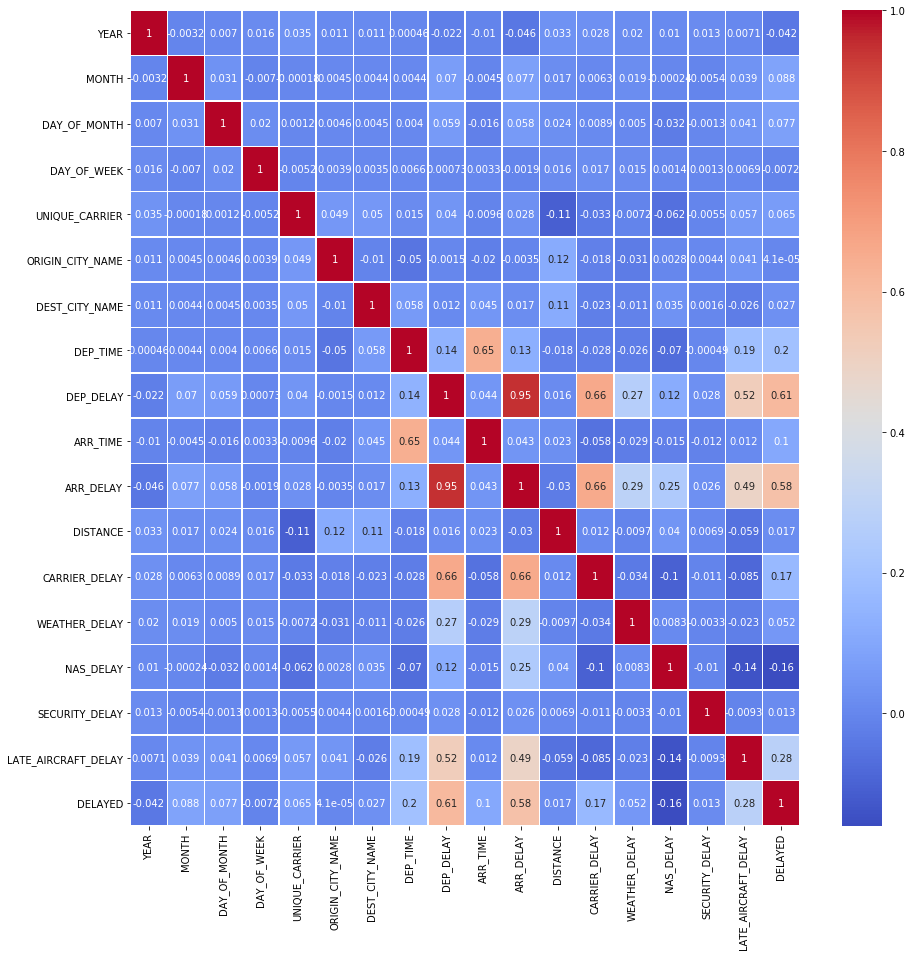

In [96]:
f,ax=plt.subplots(figsize=(15,15))
sns.heatmap(full_data.corr(), cmap = 'coolwarm', annot=True, ax=ax, linewidth=.5)


In [94]:
# Can we label encode Origin and Arrive?
le = LabelEncoder()

# Encode Origin
full_data['ORIGIN_CITY_NAME'] = le.fit_transform(full_data['ORIGIN_CITY_NAME'])
ORIGIN_CITY_NAME = list(le.classes_)

# Encode DEST
full_data['DEST_CITY_NAME'] = le.fit_transform(full_data['DEST_CITY_NAME'])
DEST_CITY_NAME = list(le.classes_)

# Encode CARRIER
full_data['UNIQUE_CARRIER'] = le.fit_transform(full_data['UNIQUE_CARRIER'])
UNIQUE_CARRIER = list(le.classes_)

#print(full_data.head())


# Logistic Regression

In [100]:
# SMOTETomek-ing

smt = SMOTETomek(random_state=242)

features = ['YEAR', 'MONTH', 'DAY_OF_MONTH', 'UNIQUE_CARRIER', 'ORIGIN_CITY_NAME',
            'DEST_CITY_NAME', 'DEP_TIME', 'ARR_TIME', 'DISTANCE']

X = full_data[features]
y = full_data['DELAYED']

X_res, y_res = smt.fit_sample(X, y)

print('Original ''y'' dataset shape {}'.format(Counter(y)))
print('Resampled ''y'' dataset shape {}'.format(Counter(y_res)))

X_samp = pd.DataFrame(X_res, columns = features)
y_samp = pd.DataFrame(y_res, columns = ['DELAYED'])


Original y dataset shape Counter({0: 3013882, 1: 648986})
Resampled y dataset shape Counter({0: 2954679, 1: 2954679})


In [101]:
X_samp_train, X_samp_test, y_samp_train, y_samp_test = train_test_split(X_samp,
                                                                        y_samp, test_size=0.5, random_state=42)

In [102]:
X_samp = StandardScaler()
X_samp_train = X_samp.fit_transform(X_samp_train)
X_samp_test = X_samp.transform(X_samp_test)


In [103]:
logreg = LogisticRegression(C=20)
logreg.fit(X_samp_train, y_samp_train)


/Users/CalvinChua/Desktop/Data_Tools/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=20, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [117]:
y_samp_pred = logreg.predict(X_samp_test)

#Check accuracy
#y_samp_pred = logreg.predict(X_samp_test)
#print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_samp_test, y_samp_test)))

# Check confusion matrix
confusion_matrix = confusion_matrix(y_samp_test, y_samp_pred)
print(confusion_matrix)


[[931380 546874]
 [523779 952646]]


In [110]:
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()


0.6703272407658891

In [113]:
print(classification_report(y_samp_test, y_samp_pred))


             precision    recall  f1-score   support

          0       0.64      0.63      0.64   1478254
          1       0.64      0.65      0.64   1476425

avg / total       0.64      0.64      0.64   2954679



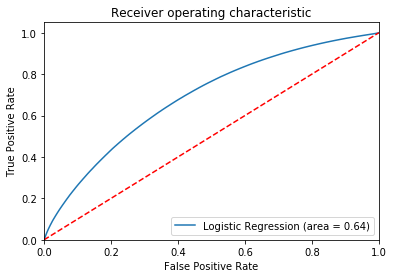

In [116]:
logit_roc_auc = roc_auc_score(y_samp_test, logreg.predict(X_samp_test))
fpr, tpr, thresholds = roc_curve(y_samp_test, logreg.predict_proba(X_samp_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


# Random Forest

In [124]:
#rf = RandomForestClassifier()


In [125]:
#cv = cross_validation.KFold(len(X_samp_train), n_folds=10, shuffle=True, random_state=5)
#print(cv)
#cvScores = cross_val_score(rf, X_samp_train, y_samp_train, cv=cv)
#print ('Mean cross validation score is: ' + str(np.mean(cvScores)))


In [126]:
#trained_model = rf.fit(X_samp_train, y_samp_train)
#print ("Trained model :: ", trained_model)
#prediction = trained_model.predict(X_samp_test)


In [127]:
#print ("Train Accuracy :: ", accuracy_score(y_samp_train, trained_model.predict(X_samp_train)))
#print ("Test Accuracy  :: ", accuracy_score(y_samp_test, prediction))


In [128]:
#y_rf_pred = rf.predict(X_samp_test)

#labels = [0, 1]
#cm = confusion_matrix(y_samp_test, y_rf_pred,labels)

#print('Accuracy: ' + str(np.round(100*float(cm[0][0]+cm[1][1])/float((cm[0][0]+cm[1][1] + cm[1][0] + cm[0][1])),2))+'%')
#print('Recall: ' + str(np.round(100*float((cm[1][1]))/float((cm[1][0]+cm[1][1])),2))+'%')
#print('Confusion matrix:')
#print(cm)

#fpr, tpr, _ = roc_curve(y_test, y_rf_pred)
#auc = np.trapz(fpr,tpr)
#print('Area under the ROC curve: ' + str(auc))

#fig = plt.figure(1)
#plt.plot(fpr,tpr,color='green')
#plt.xlabel('False positive rate (FPR)')
#plt.ylabel('True positive rate (TPR)')
#plt.title('Receiver operating characteristic (ROC)')

#fig = plt.figure(2)
#ax = fig.add_subplot(111)
#cax = ax.matshow(cm)
#plt.title('Confusion matrix for Random Forest classifier with original data')
#fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
#plt.xlabel('Predicted')
#plt.ylabel('True')
#plt.show()

In [ ]:
#fpr, tpr, _ = roc_curve(y_test, y_rf_pred)
#auc = np.trapz(fpr,tpr)
#print('Area under the ROC curve: ' + str(auc))

#fig = plt.figure(1)
#plt.plot(fpr,tpr,color='green')
#plt.xlabel('False positive rate (FPR)')
#plt.ylabel('True positive rate (TPR)')
#plt.title('Receiver operating characteristic (ROC)')

#fig = plt.figure(2)
#ax = fig.add_subplot(111)
#cax = ax.matshow(cm)
#plt.title('Confusion matrix for Random Forest classifier with original data')
#fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
#plt.xlabel('Predicted')
#plt.ylabel('True')
#plt.show()
